In [1]:
import re
import urllib.request
from bs4 import BeautifulSoup
from pandas import DataFrame
import pandas as pd
import datetime

# page nos. 1 to 1539
persian_steingass_url = 'https://dsal.uchicago.edu/cgi-bin/app/steingass_query.py?page={}'

In [32]:
def processDefChild(child):
    if child.name:
        return '<{0}>{1}</{0}>'.format(child.name, child.text.strip())
    else:
        return child.text.strip()


def getSteingassPage(page):
    with urllib.request.urlopen(persian_steingass_url.format(page)) as response:
        html = response.read()
        html = html.decode('utf-8')
    bs = BeautifulSoup(html)
    df = DataFrame([{
            'definition': re.sub(r'^\s*,', '', ' '.join(processDefChild(sib)
                for sib in hw.next_siblings)).strip(),
            'pa': hw.pa.string,
            'ro': hw.i.string if hw.i else None,
            'lang': hw.parent.lang.string if hw.parent.lang else None,
            'page': page
            } for hw in bs.find_all('hw')])
    if len(df) == 0:
        return df
    else:
        return df[['pa', 'ro', 'definition', 'lang', 'page']]

In [33]:
#DON'T RERUN

pages = []

for page in range(1, 1540):
    print('=', end='')
    if page % 5 == 0:
        print('|', end='')
        if page % 50 == 0:
            print(page, datetime.datetime.now())
    pages.append(getSteingassPage(page))

FullDict = pd.concat(pages)

FullDict.to_csv('steingass.csv')

=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|50 2022-02-02 12:35:41.501205
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|100 2022-02-02 12:36:04.405170
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|150 2022-02-02 12:36:28.232655
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|200 2022-02-02 12:36:51.248119
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|250 2022-02-02 12:37:14.052146
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|300 2022-02-02 12:37:37.976949
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|350 2022-02-02 12:38:00.721211
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|400 2022-02-02 12:38:23.681764
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|450 2022-02-02 12:38:46.471614
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|500 2022-02-02 12:39:09.055676
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|550 2022-02-02 12:39:31.986009


In [35]:
FullDict = pd.read_csv('steingass.csv')
SUBDEF_CHAR = '—'

FullDict['def_len'] = FullDict.definition.str.len()
FullDict['subdef_count'] = FullDict.definition.fillna('').apply(lambda d: len(d.split(SUBDEF_CHAR)))

<AxesSubplot:>

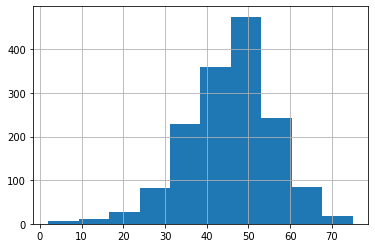

In [36]:
#Entries per page
FullDict.page.value_counts().hist()

In [37]:
# missings pages are all due to continuations of long entries, grouped withfollowing pages

for p in range(1, 1540):
    if not p in list(FullDict.page):
        print(p)

2
41
486
520
665
666


In [38]:
# Length of definitions varies a lot

FullDict.definition.str.len().describe()

count    69887.000000
mean        84.009229
std        206.624045
min          2.000000
25%         22.000000
50%         41.000000
75%         86.000000
max      19426.000000
Name: definition, dtype: float64

In [40]:
# top words by definition length

'; '.join(list(FullDict.sort_values('def_len', ascending=False)[:150].ro))

'sar; dast; āb; ḵẖẉush, ḵẖẉash; az; sang; ḵẖat̤t̤; ahl; gil; kār; yāʼ, yā; chashm; ʻalm; dandān; ḥarf; ṣāḥib; g̠ẖair; rāh; ātish; ḵẖūd; īn; ḵẖūn; rawī; marg̠ẖ; dil; zabān, zubān; gosh; faʻl; ḥaqq, ḥaq; nān; kashīdan; tīr; bād; zar; parda; rang; ʻalá; h; roz; dāman; suḵẖun, suḵẖan, saḵẖan, saḵẖun; dam; ḵẖāna; pusht; gard; jāma; kulāh; teg̠ẖ; dar; ḵẖāk; daryā; ʻain; bāz; pāy; angusht; ʻarẓ; jān; ḵẖẉāb; sher; qalb; naqsh; giriftan; taḵẖt; nafs; ʻanān; shāḵẖ; lab; shab; dāg̠ẖ; pas; taḵẖta; zīr, zer; qat̤ʻ; y; band; chashma; ʻālam; kāsa; dār; qadm; ḵẖam; chūb, chob; gara; pesh; kamar; āyina; husn; rishta; jamʻ; ism; chirāg̠ẖ; kāmān; māh; jām; tuḵẖm; naql; naz̤r; ganj; charḵẖ; diraḵẖt; panja; pīr; mail; t̤arf; nāma; bār; ʻarq; ḵẖār; qabl; kāg̠ẖaẕ, kāg̠ẖiẕ; ḥurūf; māl; sharāb; naʻl; dard; nāḵẖun; dīda; qaẓā; nām; shamsher; kashtī; ḥukm; kala; zamīn; bar sar; kardan; w; cha; raish; m; man; ban; raug̠ẖan; gāu, gāo, gāv; baḥr; qūwat, quwwat; qafl; par, parr; ḥalqat, ḥalqa; abū; nishān; ashk; war

In [41]:
# top words by subdefinition count
# the one with missing romanization is mīr

'; '.join(list(FullDict.sort_values('subdef_count', ascending=False)[:150].ro.fillna('!!!')))

'sar; dast; āb; ḵẖẉush, ḵẖẉash; ahl; az; sang; gil; ḵẖat̤t̤; ʻalm; ṣāḥib; g̠ẖair; ḥarf; rāh; kār; dandān; chashm; ḵẖūd; ātish; īn; ḵẖūn; rawī; dil; marg̠ẖ; zar; zabān, zubān; kashīdan; nān; ʻalá; ḥaqq, ḥaq; bād; parda; gosh; ḵẖāna; suḵẖun, suḵẖan, saḵẖan, saḵẖun; faʻl; roz; dam; rang; dāman; sher; pusht; daryā; dār; tīr; ḵẖẉāb; ḵẖāk; pas; ism; diraḵẖt; jāma; pāy; teg̠ẖ; shab; giriftan; gard; zīr, zer; lab; angusht; ʻālam; jān; ʻanān; kāsa; chūb, chob; husn; dar; taḵẖta; ḥurūf; chashma; pesh; dard; naqsh; kāmān; kulāh; raug̠ẖan; tuḵẖm; māh; chirāg̠ẖ; qadm; shāḵẖ; kardan; bāz; qūwat, quwwat; gara; māl; bilā (bi-lā); dīda; qat̤ʻ; āyina; taḵẖt; sharāb; nafs; kashtī; shamʻ; pīr; zamīn; abū; ḵẖār; rishta; dāg̠ẖ; jauhar; baḥr; waqt; cha; zadan; har; jām; ḵẖam; āstīn; jāy; arbāb; !!!; bāg̠ẖ; ḥamá; ʻain; nām; jamʻ; ʻarq; ganj; gāu, gāo, gāv; ḥukm; ʻuẓlat; panja; ḥalqat, ḥalqa; kamar; rag; nāḵẖun; ashk; bar sar; ʻand, ʻind, ʻund; qalm; chādar; ban; charḵẖ; mā; koh, kūh; nihādan; man; ẕī; tā; bur

In [42]:
subdefs = []

for _, row in FullDict[FullDict['subdef_count'] > 1].iterrows():
    for subdef in row.definition.split(SUBDEF_CHAR)[1:]:
        subdefs.append({
            'hw_ro': row['ro'],
            'subdef': subdef,
            'page': row['page'],
            'subdef_len': len(subdef)
        })

#DataFrame(subdefs).sample(50)

DataFrame(subdefs).sort_values('subdef_len', ascending=False)[:50]

,hw_ro,subdef,page,subdef_len
31538,"yāʼ, yā",i. <i>yāʼi (yāyi) istimrārī</i> (being <i>maj...,1524,5473
15428,sī laḥn,1. <i>ārāyishi ḵẖẉurshed (jahān)</i> ; 2. <i>...,717,953
29527,naz̤r,"<i>naz̤ar</i> (v.n.), Looking at, beholding, ...",1410,833
26729,maṣlīy,"<i>muṣallá</i> , Prayed; merciful, propitious...",1254,757
31280,"halāl, hilāl","<i>hilāl</i> (v.n. 3 of <pa>هلّ</pa> ), Agree...",1505,671
24722,m,am</i> (after a noun terminating in a vowel f...,1136,631
18172,ʻarf,"<i>ʻurf</i> , Being known, public, notorious;...",844,611
23027,kanda,"<i>kunda</i> , The stocks for offenders, a ki...",1054,610
21473,qamʻ,"<i>qamaʻ</i> (v.n.), Suffering from a fistula...",989,524
28696,mail,"<i>mīl</i> , A mile of four thousand cubits o...",1363,522


In [43]:
FullDict[FullDict.ro.isnull()].sort_values('def_len', ascending=False)

,Unnamed: 0,pa,ro,definition,lang,page,def_len,subdef_count
62009,23,مير,NaN,"(for A. <pa>امير</pa> ), An emperor, prince, l...",a,1360,1414.0,23
39207,8,ع ʻ,NaN,called <i>ʻaini g̠ẖair manqūt̤a</i> or <i>ʻain...,NaN,828,824.0,1
37267,46,ص,NaN,The seventeenth letter of the Arabic-Persian a...,NaN,777,635.0,1
30662,54,س,NaN,"called <i>sīni g̠ẖair manqūt̤a, sīni muhmala</...",NaN,637,307.0,1
68463,21,همز,NaN,"(v.n.), Squeezing (in the hand); making a sign...",A,1510,283.0,2
15676,14,تععيل,NaN,"Causing to be unemployed; rendering vacant, vo...",A,309,253.0,2
1007,26,اختلال,NaN,"Being lean, emaciated; standing in need; sewin...",A,24,232.0,3
5387,19,انشاز,NaN,Raising (anything) from its place; collecting ...,A,111,154.0,1
49127,6,گاو نبطونك,NaN,"(?), (in the dialect of Shīrāz) A kind of spur...",NaN,1074,137.0,1
62649,27,ناشبسته,NaN,"(?), Unwashed (the word given by Meninsky is e...",NaN,1373,101.0,1


In [44]:
FullDict[FullDict.definition.isnull()]

,Unnamed: 0,pa,ro,definition,lang,page,def_len,subdef_count
478,8,آتش آلود,ātish-ālūd,NaN,NaN,13,NaN,1


In [232]:
FullDict.fillna('_').lang.value_counts() #.plot.pie()

_        35328
A        25321
a         8141
T          386
G          258
H          150
t          111
SY          38
M           28
a t         26
h           14
L           10
g a          9
S            9
E            9
R            8
t a          6
g            6
ā            5
P            5
a h          3
m            3
A P          2
B            1
SP           1
o            1
a p t        1
SY.          1
HE           1
H.           1
PORT.        1
A G          1
U            1
A T          1
r            1
Name: lang, dtype: int64

In [165]:
getSteingassPage(24)

,pa,ro,def,lang,page
0,اخترام,iḵẖtirām,"Tearing; destroying, extirpating; cutting off,...",A,24
1,اخترسپاه,aḵẖtar-sipāh,A sovereign whose army is numerous as the stars.,None,24
2,اخترستان,aḵẖtaristān,Name of a treatise on astronomy.,None,24
3,اختر شمار,aḵẖtar-shumār,An astronomer.,None,24
4,اختر ضمير,aḵẖtar-ẓamīr,Of an enlightened mind; of a bright intellect.,a,24
5,اختر گراى,aḵẖtar-girāy,"Who examines the stars, investigates their cou...",None,24
6,اخترگو,aḵẖtar-go (gū),"An astrologer, augur.",None,24
7,اخترى,aḵẖtarī,"A diviner, soothsayer.",None,24
8,اختزاع,iḵẖtizāʻ,"Tearing away, alienating (one) from his kindred.",A,24
9,اختزال,iḵẖtizāl,"Tearing away, alienating from kindred; being a...",A,24


In [11]:
with urllib.request.urlopen(persian_steingass_url.format(1103)) as response:
    html = response.read()
    html = html.decode('utf-8')
    bs = BeautifulSoup(html)

In [31]:

[{
    'definition': [processDefChild(sib) for sib in hw.next_siblings],
    'pa': hw.pa.string,
    'ro': hw.i.string if hw.i else None,
    'lang': hw.parent.lang.string if hw.parent.lang else None
    } for hw in bs.find_all('hw')]

[{'definition': [' , A calf; a young camel or elephant; young in years; a dolt, a blockhead; — ',
   '<i>gosālaʼi falak</i>',
   ', The sign Taurus; — ',
   '<i>gosāla murda pur kāh kardan</i>',
   ', To stuff a dead calf with straw (which is put in sight of the cow to make her yield milk). \n\t\t\t'],
  'pa': 'گو ساله',
  'ro': 'go-sāla',
  'lang': None},
 {'definition': [' , A calf-worshipper. \n\t\t\t'],
  'pa': 'گوساله پرست',
  'ro': 'gosāla-parast',
  'lang': None},
 {'definition': [' , A sheep, a ram; a goat (the latter meaning rather incorrect, yet allowable). \n\t\t\t'],
  'pa': 'گوسپند',
  'ro': 'gospand',
  'lang': None},
 {'definition': [' , A shepherd. \n\t\t\t'],
  'pa': 'گوسپند چران',
  'ro': 'gospand-charān',
  'lang': None},
 {'definition': [' , (sheep-slaying) Name of the Muhammadan festival ',
   '<i>īdi qurbān</i>',
   ' (see ',
   '<pa>عید</pa>',
   '). \n\t\t\t'],
  'pa': 'گوسپند کشان',
  'ro': 'gospand-kushān',
  'lang': None},
 {'definition': [' , A breach, break